# Create multi layer perceptron model with MNIST data


In [11]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [12]:
cd /content/drive/MyDrive/colab/

/content/drive/MyDrive/colab


## 1. Module Import

In [13]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn # neural network를 만들 때 필요한 함수를 모아놓은 모듈
import torch.nn.functional as F # torch.nn 중에서도 자주 사용되는 함수
from torchvision import transforms, datasets # CV분야에서 자주 사용되는 torchvision 

## 2. Check version

In [14]:

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [15]:
DEVICE

device(type='cuda')

In [16]:
torch.__version__

'1.9.0+cu102'

In [17]:
batch_size = 32
epochs = 10

## 3. MNIST 데이터 다운로드(train, test 분리)

`datasets.MNIST`를 이용해서 데이터를 불러올 수 있고, 이미지 형태이기 때문에 `transforms.ToTensor` 옵션을 사용해 텐서형태로 불러옴. 다만 MLP 모델은 input data의 값이 커질수록 불안정해지므로 정규화를 0\~255 사이의 텐서값을 0~1 범위로 정규화하여 불러움

In [18]:
train_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = False,
                               download = True,
                               transform = transforms.ToTensor())

위에서 다운로드한 MNIST 데이터셋을 미니 배치 단위로 분리해서 지정. 이미지 데이터를 배치 사이즈 단위로 미니 배치를 구성하게 됨.  
즉, 미니 배치 1개 = 배치 사이즈 32

In [24]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [19]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/MNIST
    Split: Train
    StandardTransform
Transform: ToTensor()

## 4. 데이터 확인하기 (1)

In [30]:
for (X_train, y_train) in train_loader:
    print('X_train: ', X_train.size(), 'type: ', X_train.type())
    print('y_train: ', y_train.size(), 'type: ', y_train.type())
    break

X_train:  torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor


출력 결과 해석  
- 32개의 이미지 데이터가 1개의 미니 배치를 구성
- 가로 28, 세로 28 픽셀
- 채널 1 -> Gray Scale (흑백)
- type 도 추가로 확인할 수 있음

## 5. 데이터 확인하기 (2)

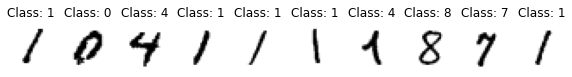

In [32]:
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28,28), cmap = "gray_r")
    plt.title("Class: " + str(y_train[i].item()))

## 6. MLP 모델링

In [33]:
class Net(nn.Module): # nn.Module method 상속 -> nn.Module 내의 함수를 Net class 안에서 이용가능함
    
    # 초기화
    def __init__(self):
        super(Net, self).__init__()
        # Fully Connected Layer
        self.fc1 = nn.Linear(28 * 28, 512) # 처음 input layer의 노드수 = 가로*세로*채널수 
        self.fc2 = nn.Linear(512, 256) 
        self.fc3 = nn.Linear(256, 10) # Output : 0~9까지의 이미지 label -> 10개 // Loss를 계산하기 위해서 개수 똑같이 맞춰야 함
    
    # 순전파
    def forward(self, x):
        x = x.view(-1, 28*28) # MLP 모델은 1차원 데이터를 입력 받음. 기존 데이터는 (28, 28)의 2차원 데이터이므로 view를 이용하여 28*28개의 1차원 데이터로 변환
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x


## 7. 옵티마이저, 손실함수 설정

In [ ]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.paramters(), lr = 0.01, momentum = 0.5) # stochastic gradient descent 
criterion = nn.CrossEntropyLoss() # 손실함수 : CrossEntropy

[Cross Entropy Loss function](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in Pytorch

## 8. train 데이터에 대한 모델 성능 확인하는 함수 정의

In [ ]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx,(image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch {} [{}/{}(:.0f}%)] /t Train Loss: {:.6f}".format(Epoch, 
                                                                                batch_idx * len(image),
                                                                                len(train_loader.dataset), 
                                                                                100. * batch_idx / len(train_loader),
                                                                                loss.item()))